In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset Dependencies
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle



2023-11-21 19:32:32.973298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-21 19:32:32.973312: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize the pixel values to the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def loss_func(label, pred):
    return 0.5*(label - pred)**2


In [4]:
class NN():
    def __init__(self, params):
        self.params = params # format: [input_size, a1_size, a1_size, ...  output_size]
        self.weight_list = [np.random.normal(size=[params[i], params[i+1]], loc = 0.0, scale = 1.0) for i in range(len(params)-1)]
        self.bias_list = [np.random.normal(size=[params[i+1],], loc = 0.0, scale = 1.0) for i in range(len(params)-1)]
        self.activations_list = []  # [input_vector , a1_vector, a2_vector, ... output_vector]
        self.dCdw_list_acumulated =  [0]*(len(params)-1) # initial value
        self.dCdb_list_acumulated =  [0]*(len(params)-1) # initial value

        print(" ----- Neural net layout -----")
        print(f"    Input with {params[0]} valeus")
        for i in range(len(self.params)-2):
            print(f"    Hidden layer {i+1} with {params[i+1]} nodes")
        print(f"    Output with {params[-1]} nodes")
        print(" -----------------------------")


    def reset_cumulated_values(self):
        self.dCdw_list_acumulated =  [0]*(len(self.params)-1) # initial value
        self.dCdb_list_acumulated =  [0]*(len(self.params)-1) # initial value


    def forward(self, input):
        self.activations_list = [input] # Creates a list for the activation with the input vector as it is the a0 layers
        for i in range(len(self.params)-1): # Adds the other layers (n-1)layers because the input has been added already
            zi = np.dot(np.transpose(self.weight_list[i]), self.activations_list[i]) + self.bias_list[i]
            ai = sigmoid(zi)
            self.activations_list.append(ai)
        return ai
        


    def backpropagation(self, label, batch_size):
        dCdw_list = [] # OBS: the values are gonna be added from the last to the first item
        dCdb_list = [] # OBS: the values are gonna be added from the last to the first item
        first_calc = True
        for i in range(len(self.params)-1): # iters over all hidden layers + 1 output    ->   len(params)-1 
            if first_calc == True:
                output = self.activations_list[::-1][i]
                dCdout = (output - label)

                dadz = self.activations_list[::-1][i]*(1 - self.activations_list[::-1][i])
                cumulative_partials = dadz*dCdout # initial value
                first_calc = False
            else:
                dzda = self.weight_list[::-1][i-1]

                dadz = self.activations_list[::-1][i]*(1 - self.activations_list[::-1][i])
                cumulative_partials = dadz*np.dot(dzda, cumulative_partials)

            
            dzdw = self.activations_list[::-1][i+1] # element l-1 in the NN standard notation, but because the list in inverted, its index is i+1
            dzdb = 1

            
            transp_cumulative_partials = np.transpose(cumulative_partials.reshape(-1,1))

            gradient_w = np.dot(dzdw.reshape(-1,1), transp_cumulative_partials)
            gradient_b = dzdb*cumulative_partials
            
            dCdw_list.append(gradient_w)
            dCdb_list.append(gradient_b)


            self.dCdw_list_acumulated[i] += gradient_w/batch_size
            self.dCdb_list_acumulated[i] += gradient_b/batch_size


    def optimization(self, alpha):
        self.weight_list = [(self.weight_list[i] - alpha*self.dCdw_list_acumulated[::-1][i]) for i in range(len(self.weight_list))] 
        self.bias_list =   [(self.bias_list[i]   - alpha*self.dCdb_list_acumulated[::-1][i]) for i in range(len(self.bias_list))]  

 
        
        
    


# Training process

In [6]:
bla = NN([784, 16, 10])

batch_size = 1
loss = 0
epoch = 5
lr = 0.5

loss_list = []
for i in range(epoch):
    loss_cumulated = 0
    # shuffle the training data for each epoch
    x_train_shuffled, y_train_shuffled = shuffle(x_train, y_train)

    for j in np.arange(batch_size, len(y_train)+1, batch_size):
        batch = zip(x_train[j-batch_size : j], y_train[j-batch_size : j])

        for x, y in batch:
            a0 = x.ravel()
            output = bla.forward(a0)

            target = np.zeros(10)
            target[y] = 1

            loss = 0.5*(target - output)**2
            loss_cumulated += sum(loss)/len(loss)

            

            bla.backpropagation(target, batch_size)

        bla.optimization(lr)
        bla.reset_cumulated_values()
    epoch_loss = loss_cumulated/len(y_train)
    loss_list.append(epoch_loss)

    print(f"Epoch {(i+1)}/{epoch},  loss: {epoch_loss}")

    loss = 0
    

 ----- Neural net layout -----
    Input with 784 valeus
    Hidden layer 1 with 16 nodes
    Output with 10 nodes
 -----------------------------
Epoch 1/5,  loss: 0.012597657906096398
Epoch 2/5,  loss: 0.007989611776676267
Epoch 3/5,  loss: 0.007252714713109729
Epoch 4/5,  loss: 0.006787764528714238
Epoch 5/5,  loss: 0.006430103248575964


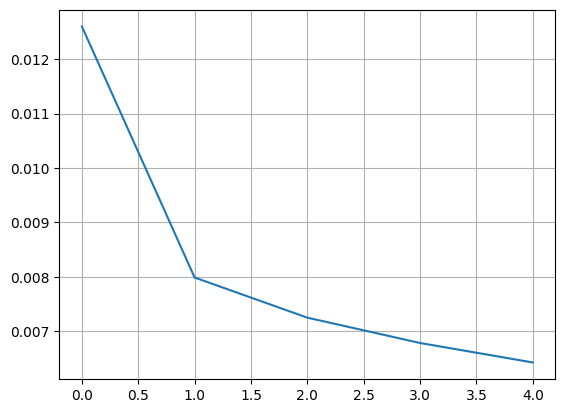

In [7]:
y_axis = loss_list
x_axis = [i for i in range(len(y_axis))]
plt.plot(x_axis, y_axis, )
plt.grid()
plt.show()

In [35]:
f = 0
v = 0
for i in range(x_test.shape[0]):
    x = x_test[i].ravel()
    y = y_test[i]
    output = bla.forward(x)
    # bla.reset()
    predicted = np.argmax(output)
    if predicted == y:
        v +=1
    else:
        f+=1
print(f"The model correctly predicted {v} out of {v+f} test cases, achieving an accuracy of {v / (v+f) * 100:.2f}%.")

The model correctly predicted 9177 out of 10000 test cases, achieving an accuracy of 91.77%.


# Visualization

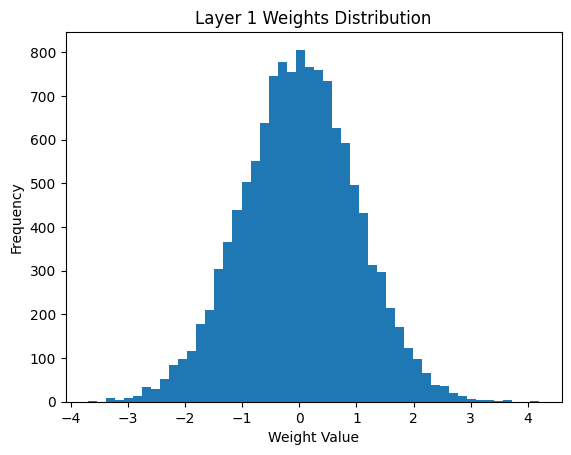

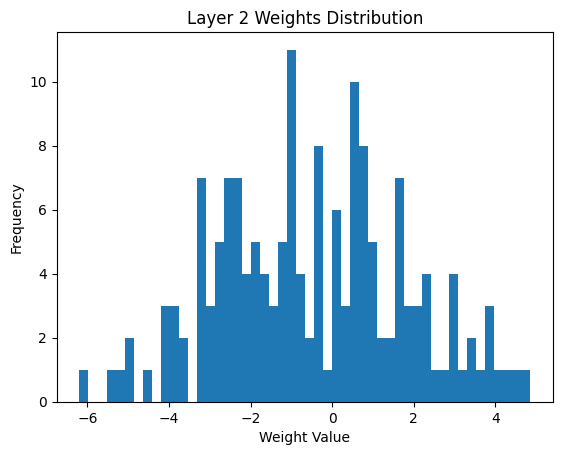

In [63]:
for i, layer_weights in enumerate(g.weight_list):
    plt.figure()
    plt.hist(layer_weights.flatten(), bins=50)
    plt.title(f'Layer {i+1} Weights Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()